<a href="https://colab.research.google.com/github/JVR27XD/MobileSAM/blob/main/EfficientSAMTFG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Clonar el repo y moverse a la carpeta

In [ ]:
!git clone https://github.com/yformer/EfficientSAM.git
%cd EfficientSAM

!pip install --upgrade pip

fatal: destination path 'EfficientSAM' already exists and is not an empty directory.
/content/EfficientSAM


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import transforms
from PIL import Image
import zipfile
import os
from efficient_sam.build_efficient_sam import build_efficient_sam_vitt, build_efficient_sam_vits
# Si queremeos:
# from squeeze_sam.build_squeeze_sam import build_squeeze_sam


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

Device: cuda


In [ ]:
# Cargar los modelos

# Ruta EfficientSAM-Ti (.pt en Drive)
checkpoint_path_ti = "/content/drive/MyDrive/Colab Notebooks/TFG/EfficientSAM/efficient_sam_vitt .pt"

# Ruta EfficientSAM-S (.zip en Drive)
zip_path_s = "/content/drive/MyDrive/Colab Notebooks/TFG/EfficientSAM/efficient_sam_vits.pt.zip"
weights_folder = "weights/"

# Descomprimir EfficientSAM-S
with zipfile.ZipFile(zip_path_s, 'r') as zip_ref:
    zip_ref.extractall(weights_folder)

# Cargar modelos
efficient_sam_vitt_model = build_efficient_sam_vitt()
checkpoint_ti = torch.load(checkpoint_path_ti, map_location="cpu")
state_dict_ti = checkpoint_ti["model"]
efficient_sam_vitt_model.load_state_dict(state_dict_ti)
efficient_sam_vitt_model.eval()

efficient_sam_vits_model = build_efficient_sam_vits()
efficient_sam_vits_model.eval()

# # squeeze_sam_model = build_squeeze_sam()
# # squeeze_sam_model.eval()

# Mover a device
efficient_sam_vitt_model.to(device)
efficient_sam_vits_model.to(device)

print("Modelos cargados.")


Modelos cargados.


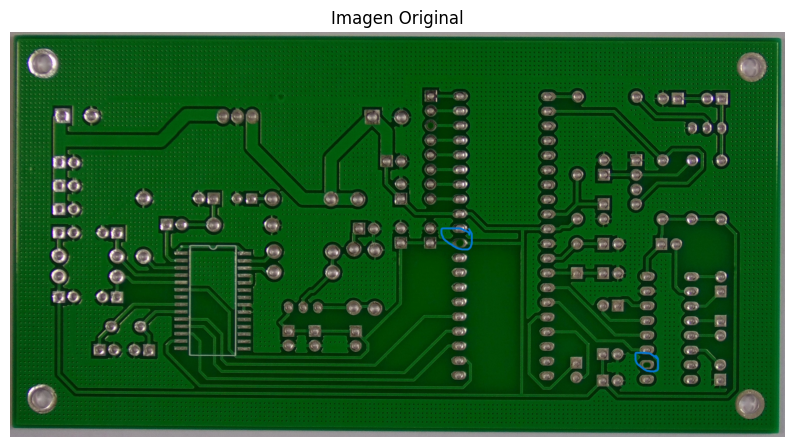

In [ ]:
# CARGAR IMAGEN

img_path = "/content/EfficientSAM/figs/examples/01_missing_hole_01.jpg"
img = Image.open(img_path).convert("RGB")
image_tensor_cpu = transforms.ToTensor()(img).unsqueeze(0).cpu()
image_tensor_gpu = transforms.ToTensor()(img).unsqueeze(0).to(device)

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis('off')
plt.title("Imagen Original")
plt.show()

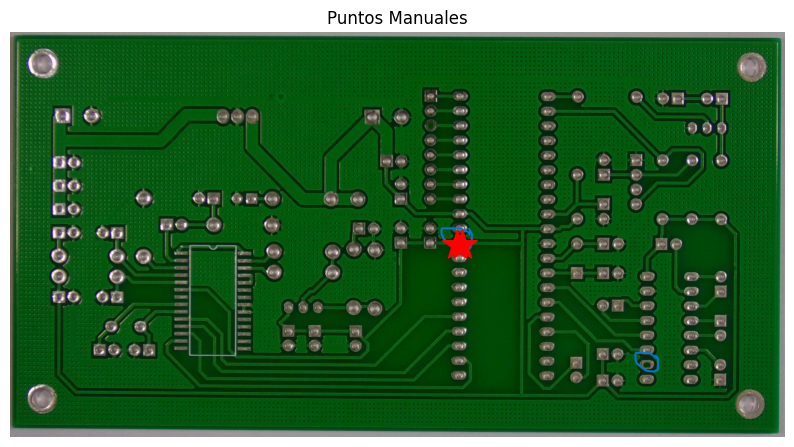

In [ ]:
# DEFINIR LOS PUNTOS

# Poner aquí tus puntos: [ [x1, y1], [x2, y2], ... ]
coords = np.array([[1750, 833], [1770, 834]])
labels = np.array([1, 1])  # foreground (1), background (0)

# Para debug:
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.scatter(coords[:, 0], coords[:, 1], color='red', marker='*', s=500)
plt.axis('off')
plt.title("Puntos")
plt.show()



In [ ]:
# FUNCIONES AUXILIARES

def run_ours_box_or_points(img_pil, pts_sampled, pts_labels, model):
    # Convertir imagen PIL → tensor
    img_tensor = transforms.ToTensor()(img_pil).unsqueeze(0).to(device)

    pts_sampled = torch.tensor(pts_sampled, device=device).reshape(1, 1, -1, 2)
    pts_labels = torch.tensor(pts_labels, device=device).reshape(1, 1, -1)

    with torch.no_grad():
        predicted_logits, predicted_iou = model(
            img_tensor,
            pts_sampled,
            pts_labels,
        )
        sorted_ids = torch.argsort(predicted_iou, dim=-1, descending=True)
        predicted_logits = torch.take_along_dim(predicted_logits, sorted_ids[..., None, None], dim=2)
        mask = torch.ge(predicted_logits[0, 0, 0, :, :], 0).cpu().numpy()

    return mask

def show_mask(mask, ax, color=(30/255, 144/255, 1, 0.6)):
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * np.array(color).reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    coords = np.array(coords)
    labels = np.array(labels)
    pos_points = coords[labels == 1]
    neg_points = coords[labels == 0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color="green", marker="*", s=marker_size, edgecolor="white", linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color="red", marker="*", s=marker_size, edgecolor="white", linewidth=1.25)



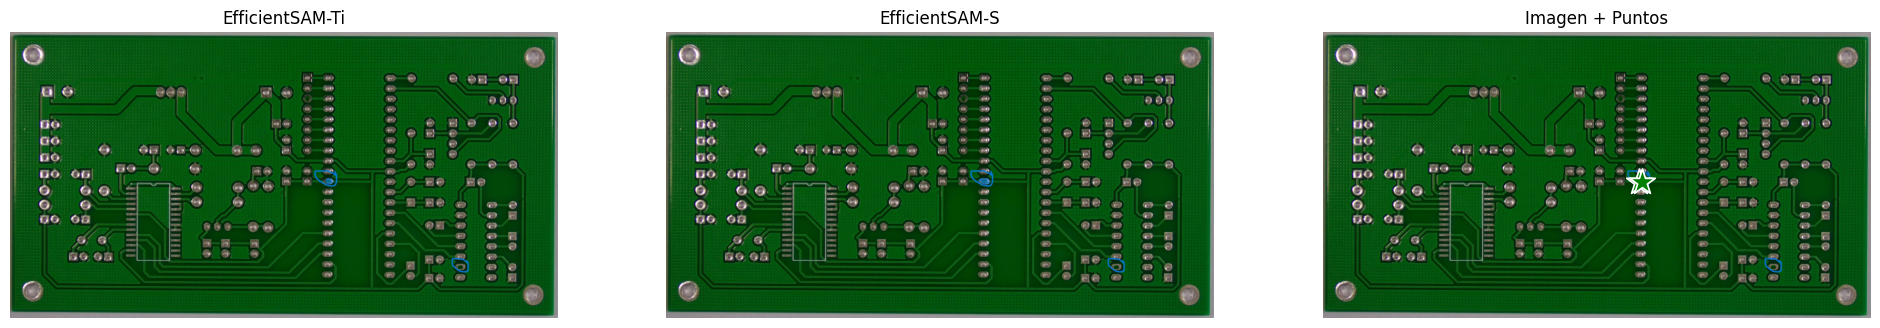

In [ ]:
# --- INFERENCIA Y VISUALIZACION ---

fig, ax = plt.subplots(1, 3, figsize=(24, 8))

# EfficientSAM-Ti (.pt)
ax[0].imshow(img)
mask_ti = run_ours_box_or_points(img, coords, labels, efficient_sam_vitt_model)
show_mask(mask_ti, ax[0])

ax[0].axis('off')
ax[0].set_title("EfficientSAM-Ti")

# EfficientSAM-S (.zip)
ax[1].imshow(img)
mask_s = run_ours_box_or_points(img, coords, labels, efficient_sam_vits_model)
show_mask(mask_s, ax[1])
ax[1].axis('off')
ax[1].set_title("EfficientSAM-S")

# Imagen original
ax[2].imshow(img)
show_points(coords, labels, ax[2])
ax[2].axis('off')
ax[2].set_title("Imagen + Puntos")

plt.show()


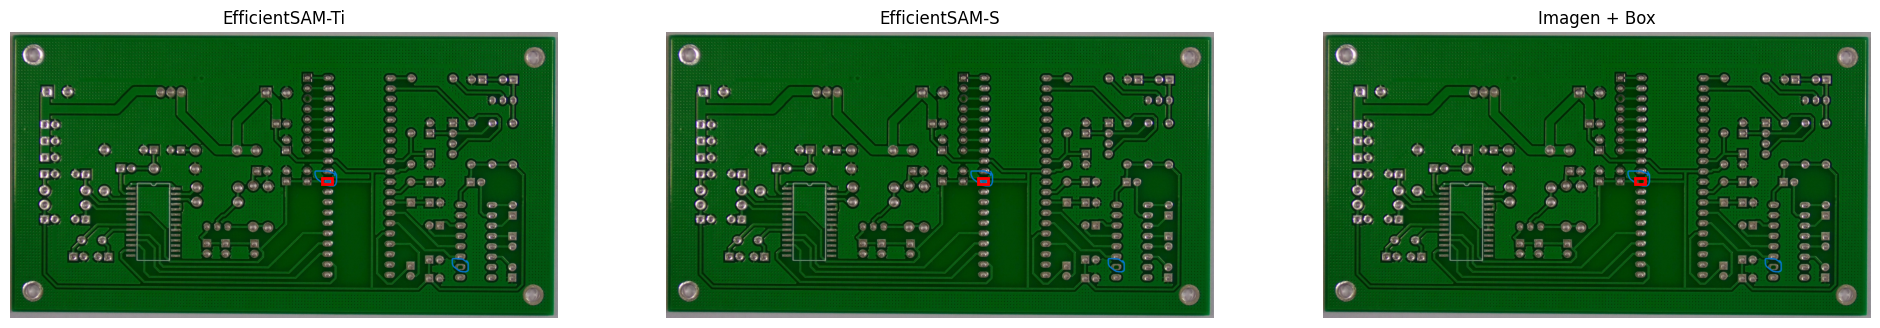

In [ ]:
import matplotlib.patches as patches

# Definir Bounding Box
x1 = 1730
y1 = 811
x2 = 1784
y2 = 844

# Definir puntos y labels
coords = np.array([[x1, y1], [x2, y2]])
labels = np.array([2, 3])

efficient_sam_vitt_model = build_efficient_sam_vitt().to("cuda" if torch.cuda.is_available() else "cpu")
efficient_sam_vitt_model.eval()

efficient_sam_vits_model = build_efficient_sam_vits().to("cuda" if torch.cuda.is_available() else "cpu")
efficient_sam_vits_model.eval()

# Mostrar imagen con resultados
fig, ax = plt.subplots(1, 3, figsize=(24, 8))

# EfficientSAM-Ti (.pt)
ax[0].imshow(img)
mask_ti = run_ours_box_or_points(img, coords, labels, efficient_sam_vitt_model)
show_mask(mask_ti, ax[0])

rect = patches.Rectangle((x1, y1), x2-x1, y2-y1,
                         linewidth=2, edgecolor='red', facecolor='none')
ax[0].add_patch(rect)

ax[0].axis('off')
ax[0].set_title("EfficientSAM-Ti")

# EfficientSAM-S (.zip)
ax[1].imshow(img)
mask_s = run_ours_box_or_points(img, coords, labels, efficient_sam_vits_model)
show_mask(mask_s, ax[1])

rect = patches.Rectangle((x1, y1), x2-x1, y2-y1,
                         linewidth=2, edgecolor='red', facecolor='none')
ax[1].add_patch(rect)

ax[1].axis('off')
ax[1].set_title("EfficientSAM-S")

# Imagen original + box
ax[2].imshow(img)

rect = patches.Rectangle((x1, y1), x2-x1, y2-y1,
                         linewidth=2, edgecolor='red', facecolor='none')
ax[2].add_patch(rect)

ax[2].axis('off')
ax[2].set_title("Imagen + Box")

plt.show()

In [ ]:
GRID_SIZE = 16


In [ ]:
!pip install git+https://github.com/facebookresearch/segment-anything.git




  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-eljn6iw5
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-eljn6iw5
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done


In [ ]:
import sys
sys.path.append('/content/segment-anything')

In [ ]:
!ls /content/segment-anything


In [ ]:
from segment_anything.utils.amg import (
    batched_mask_to_box,
    calculate_stability_score,
    mask_to_rle_pytorch,
    remove_small_regions,
    rle_to_mask,
)

from torchvision.ops.boxes import batched_nms
import torch

def process_small_region(rles):
    new_masks = []
    scores = []
    min_area = 100
    nms_thresh = 0.7
    for rle in rles:
        mask = rle_to_mask(rle[0])

        mask, changed = remove_small_regions(mask, min_area, mode="holes")
        unchanged = not changed
        mask, changed = remove_small_regions(mask, min_area, mode="islands")
        unchanged = unchanged and not changed

        new_masks.append(torch.as_tensor(mask).unsqueeze(0))
        scores.append(float(unchanged))

    masks = torch.cat(new_masks, dim=0)
    boxes = batched_mask_to_box(masks)
    keep_by_nms = batched_nms(
        boxes.float(),
        torch.as_tensor(scores),
        torch.zeros_like(boxes[:, 0]),
        iou_threshold=nms_thresh,
    )

    for i_mask in keep_by_nms:
        if scores[i_mask] == 0.0:
            mask_torch = masks[i_mask].unsqueeze(0)
            rles[i_mask] = mask_to_rle_pytorch(mask_torch)
    masks = [rle_to_mask(rles[i][0]) for i in keep_by_nms]
    return masks

def get_predictions_given_embeddings_and_queries(img, points, point_labels, model):
    predicted_masks, predicted_iou = model(
        img[None, ...], points, point_labels
    )
    sorted_ids = torch.argsort(predicted_iou, dim=-1, descending=True)
    predicted_iou_scores = torch.take_along_dim(predicted_iou, sorted_ids, dim=2)
    predicted_masks = torch.take_along_dim(
        predicted_masks, sorted_ids[..., None, None], dim=2
    )
    predicted_masks = predicted_masks[0]
    iou = predicted_iou_scores[0, :, 0]
    index_iou = iou > 0.7
    iou_ = iou[index_iou]
    masks = predicted_masks[index_iou]
    score = calculate_stability_score(masks, 0.0, 1.0)
    score = score[:, 0]
    index = score > 0.9
    score_ = score[index]
    masks = masks[index]
    iou_ = iou_[index]
    masks = torch.ge(masks, 0.0)
    return masks, iou_

def run_everything_ours(image_path, model):
    from torchvision.transforms import ToTensor
    import cv2
    model = model.cpu()
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img_tensor = ToTensor()(image)
    _, original_image_h, original_image_w = img_tensor.shape
    xy = []
    for i in range(GRID_SIZE):
        curr_x = 0.5 + i / GRID_SIZE * original_image_w
        for j in range(GRID_SIZE):
            curr_y = 0.5 + j / GRID_SIZE * original_image_h
            xy.append([curr_x, curr_y])
    xy = torch.from_numpy(np.array(xy))
    points = xy
    num_pts = xy.shape[0]
    point_labels = torch.ones(num_pts, 1)
    with torch.no_grad():
        predicted_masks, predicted_iou = get_predictions_given_embeddings_and_queries(
            img_tensor.cpu(),
            points.reshape(1, num_pts, 1, 2).cpu(),
            point_labels.reshape(1, num_pts, 1).cpu(),
            model.cpu(),
        )
    rle = [mask_to_rle_pytorch(m[0:1]) for m in predicted_masks]
    predicted_masks = process_small_region(rle)
    return predicted_masks

def show_anns_ours(mask, ax):
    ax.set_autoscale_on(False)
    img = np.ones((mask[0].shape[0], mask[0].shape[1], 4))
    img[:,:,3] = 0
    for ann in mask:
        m = ann
        color_mask = np.concatenate([np.random.random(3), [0.5]])
        img[m] = color_mask
    ax.imshow(img)


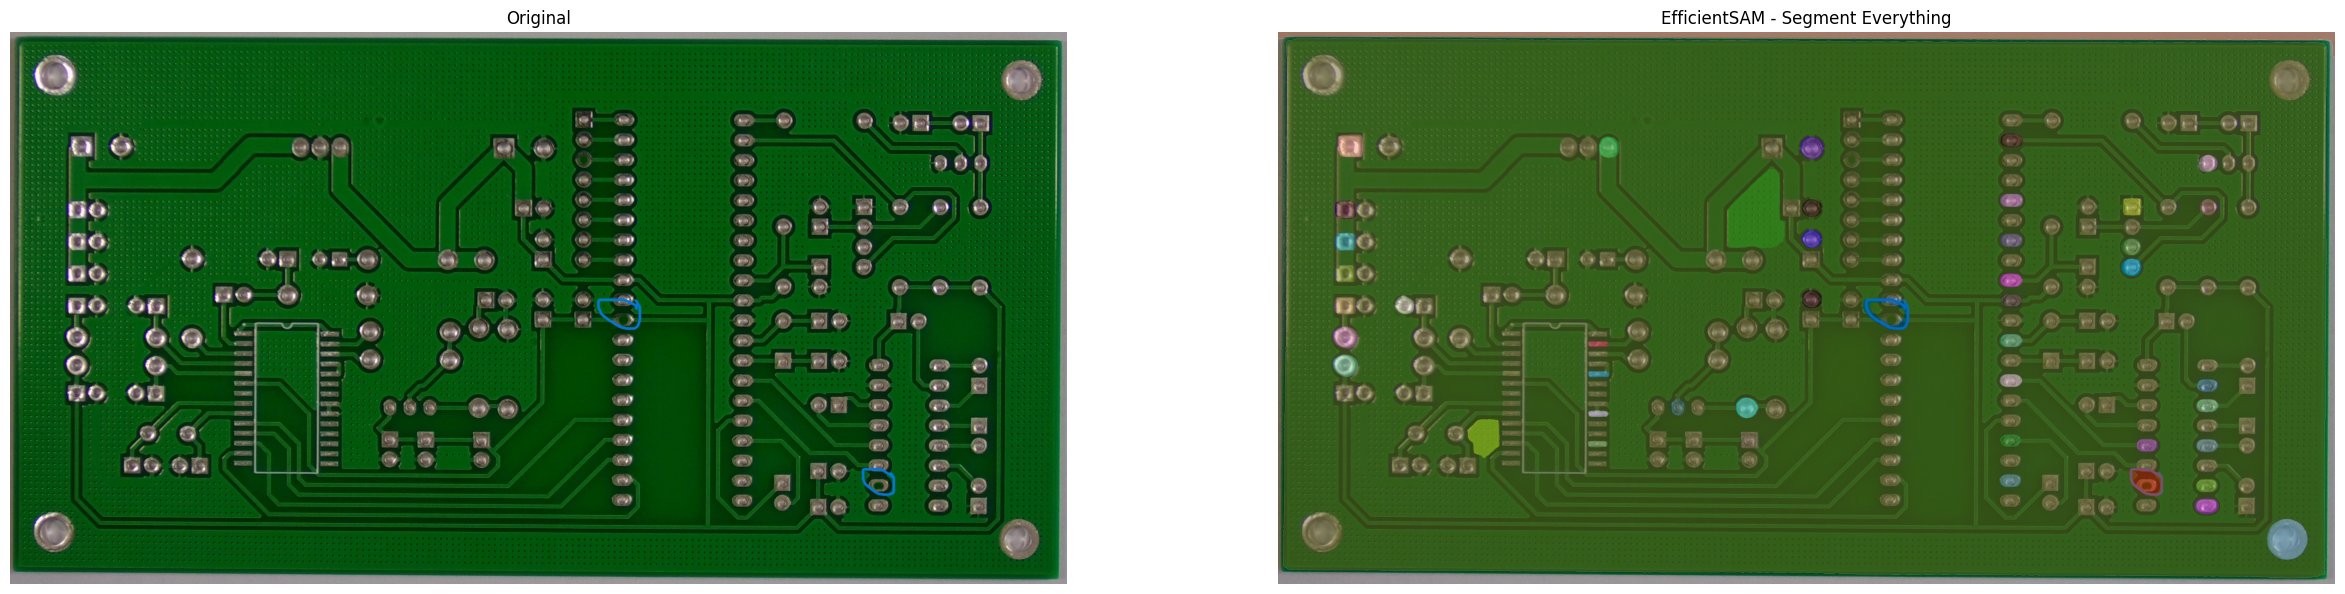

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
fig, ax = plt.subplots(1, 2, figsize=(30, 30))

# Imagen
image_path = "/content/EfficientSAM/figs/examples/01_missing_hole_01.jpg"
image = np.array(Image.open(image_path))

# Mostrar original
ax[0].imshow(image)
ax[0].title.set_text("Original")
ax[0].axis('off')

# Segment Everything
ax[1].imshow(image)
mask_efficient_sam_vits = run_everything_ours(image_path, efficient_sam_vits_model)
show_anns_ours(mask_efficient_sam_vits, ax[1])
ax[1].title.set_text("EfficientSAM - Segment Everything")
ax[1].axis('off')

plt.show()


EfficientSAM-Ti → tiempo: 0.209 sec, VRAM: 205.9 MB
EfficientSAM-S  → tiempo: 0.265 sec, VRAM: 205.9 MB


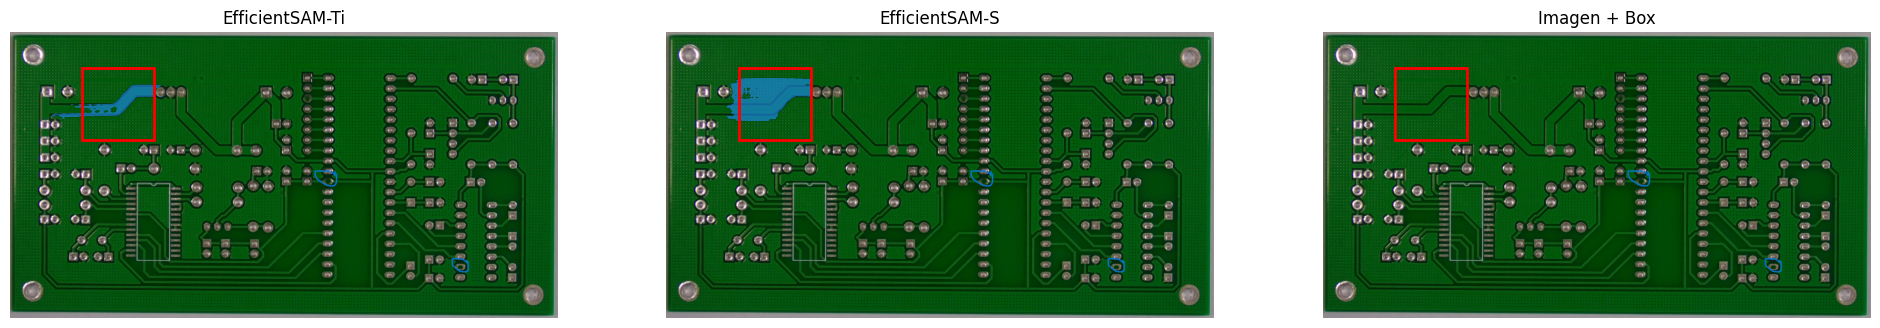

In [ ]:
import time# Definir Bounding Box
x1 = 400
y1 = 200
x2 = 800
y2 = 600

# Definir puntos y labels (bounding box prompt)
coords = np.array([[x1, y1], [x2, y2]])
labels = np.array([2, 3])

# Cargar imagen (modifica la ruta)
image_path = "/content/EfficientSAM/figs/examples/01_missing_hole_01.jpg"
img = np.array(Image.open(image_path))

# Asegurar modelos en GPU
device = "cuda" if torch.cuda.is_available() else "cpu"

efficient_sam_vitt_model = build_efficient_sam_vitt().to(device)
efficient_sam_vitt_model.eval()

efficient_sam_vits_model = build_efficient_sam_vits().to(device)
efficient_sam_vits_model.eval()

# --- EfficientSAM-Ti ---
torch.cuda.empty_cache()
start_time_ti = time.time()

mask_ti = run_ours_box_or_points(img, coords, labels, efficient_sam_vitt_model)

end_time_ti = time.time()
elapsed_time_ti = end_time_ti - start_time_ti
vram_ti = torch.cuda.memory_allocated(device) / 1024**2  # en MB

# --- EfficientSAM-S ---
torch.cuda.empty_cache()
start_time_s = time.time()

mask_s = run_ours_box_or_points(img, coords, labels, efficient_sam_vits_model)

end_time_s = time.time()
elapsed_time_s = end_time_s - start_time_s
vram_s = torch.cuda.memory_allocated(device) / 1024**2  # en MB

# --- Mostrar comparativa ---
print(f"EfficientSAM-Ti → tiempo: {elapsed_time_ti:.3f} sec, VRAM: {vram_ti:.1f} MB")
print(f"EfficientSAM-S  → tiempo: {elapsed_time_s:.3f} sec, VRAM: {vram_s:.1f} MB")

# --- Mostrar visual ---
fig, ax = plt.subplots(1, 3, figsize=(24, 8))

# Ti
ax[0].imshow(img)
show_mask(mask_ti, ax[0])
rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, edgecolor='red', facecolor='none')
ax[0].add_patch(rect)
ax[0].axis('off')
ax[0].set_title("EfficientSAM-Ti")

# S
ax[1].imshow(img)
show_mask(mask_s, ax[1])
rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, edgecolor='red', facecolor='none')
ax[1].add_patch(rect)
ax[1].axis('off')
ax[1].set_title("EfficientSAM-S")

# Original
ax[2].imshow(img)
rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, edgecolor='red', facecolor='none')
ax[2].add_patch(rect)
ax[2].axis('off')
ax[2].set_title("Imagen + Box")

plt.show()